## Lab: RNN with Forecasting

### Wind Turbine Power Prediction with RNN

This lab uses a Recurrent Neural Network to predict wind turbine power output.
* [Data link](https://www.kaggle.com/code/ahmedfathygwely/wind-turbine-dataset-machine-learning-rnn-times/input)

### Step 0: Load libraries & Data

In [2]:
# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the data
df = pd.read_csv('T1.csv')


In [3]:
# Display basic information

print(f"Wind Turbine dataset shape: {df.shape}") 
print(df.head())

Wind Turbine dataset shape: (50530, 5)
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  


### Step 1: Prepare the data

In [4]:
# Step 1: Prepare the data

df['Date Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M') # creating new field in datetime format
df = df.drop('Date/Time', axis=1) # dropping original datetime field
df.set_index('Date Time', inplace=True) # setting the datetime field as the index
df.head() # verifying reindexing

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [5]:
print("Missing Values by Column:")
print(df.isnull().sum())

Missing Values by Column:
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64


Helpfully, the dataset contains no missing values.

In [6]:
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)  
count        50530.000000  
mean           123.687559  
std             93.443736  
min              0.000000  
25%             49.315437  
50%             73.712978  
75%            201.696720  
max            359.997589  


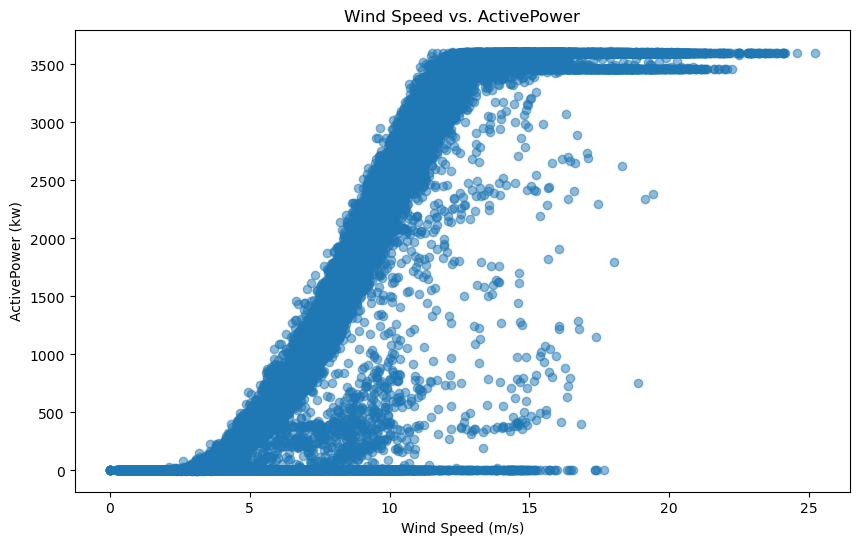

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('ActivePower (kw)')
plt.title('Wind Speed vs. ActivePower')
plt.show()

There is a clear correlation between wind speed and active power.

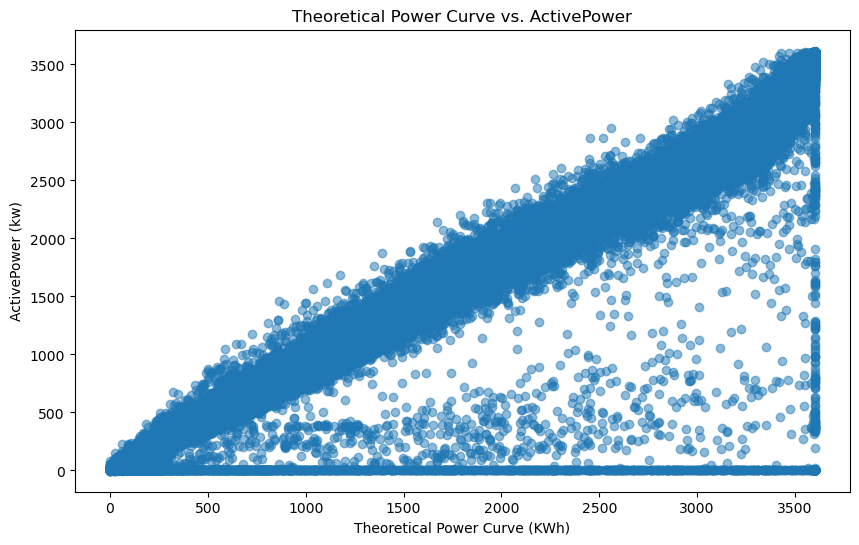

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Theoretical_Power_Curve (KWh)'], df['LV ActivePower (kW)'], alpha=0.5)
plt.xlabel('Theoretical Power Curve (KWh)')
plt.ylabel('ActivePower (kw)')
plt.title('Theoretical Power Curve vs. ActivePower')
plt.show()

The theoretical power curve generally tracks nicely to the active power.

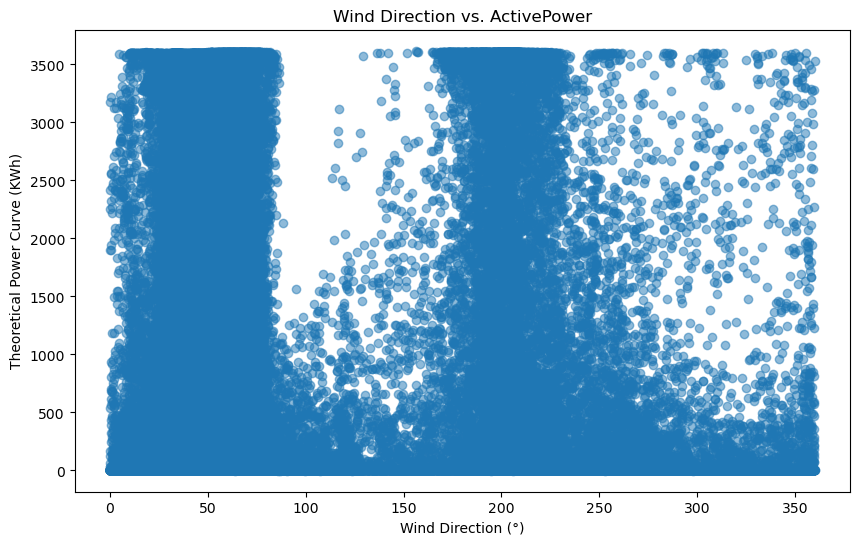

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Direction (°)'], df['LV ActivePower (kW)'], alpha=0.5)
plt.xlabel('Wind Direction (°)')
plt.ylabel('Theoretical Power Curve (KWh)')
plt.title('Wind Direction vs. ActivePower')
plt.show()

Wind direction has a clear relationship to active power (peaks when wind is at 0 degrees and 180 degrees)

In [10]:
df2 = df.drop('Theoretical_Power_Curve (KWh)', axis=1) # dropping theoretical curve in favor of keeping observed data only
data = df2.values
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))
data.shape

(151590, 1)

### Step 2: Create sequences

In [11]:
# Step 2: Create sequences
seq_size = 36 # creating 6 hour windows (6 observations per hour x 6 hours)

X = []
y = []

for i in range(seq_size, len(df)):
    X.append(data[i-seq_size:i, 0])
    y.append(data[i, 0])

X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape, y.shape


((50494, 36, 1), (50494,))

### Step 3: Split the data

In [12]:
# Step 3: Split the data
train_size = int(len(X) * 0.8) # 80 / 20 train / test split

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40395, 36, 1), (40395,), (10099, 36, 1), (10099,))

### Step 4: Build the RNN Model

In [13]:
# Step 4: Build the RNN Model

model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(seq_size, 1), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(25, activation='tanh', input_shape=(seq_size, 1)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 36, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________


In [14]:
# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=5,               # Number of epochs with no improvement after which to stop
    min_delta=0.0005,          # Minimum change to qualify as improvement
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

# model checkpoint
checkpoint_filepath = './best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,      # Only save when there's improvement
    mode='min',               # The direction is 'min' for loss
    verbose=1                 # Show progress
)

callbacks = [
    early_stopping,
    model_checkpoint
]

### Step 5: Train the model

In [15]:
# Step 5: train the model
history = model.fit(
    X_train, y_train, 
    epochs=20,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
1010/1010 [==============================] - ETA: 0s - loss: 0.0320
Epoch 1: val_loss improved from inf to 0.00456, saving model to .\best_model.keras
1010/1010 [==============================] - 27s 23ms/step - loss: 0.0320 - val_loss: 0.0046
Epoch 2/20
1008/1010 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 2: val_loss improved from 0.00456 to 0.00337, saving model to .\best_model.keras
1010/1010 [==============================] - 23s 23ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 3/20
1010/1010 [==============================] - ETA: 0s - loss: 0.0054
Epoch 3: val_loss did not improve from 0.00337
1010/1010 [==============================] - 27s 26ms/step - loss: 0.0054 - val_loss: 0.0035
Epoch 4/20
1007/1010 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 4: val_loss did not improve from 0.00337
1010/1010 [==============================] - 25s 25ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 5/20
1010/1010 [==========================

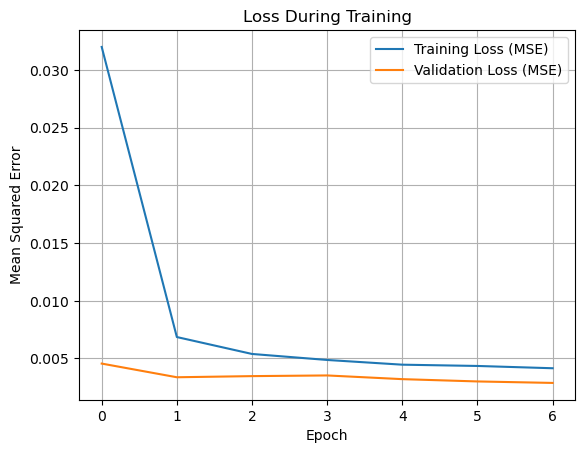

In [29]:
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Loss During Training')
plt.grid(True)
plt.legend()

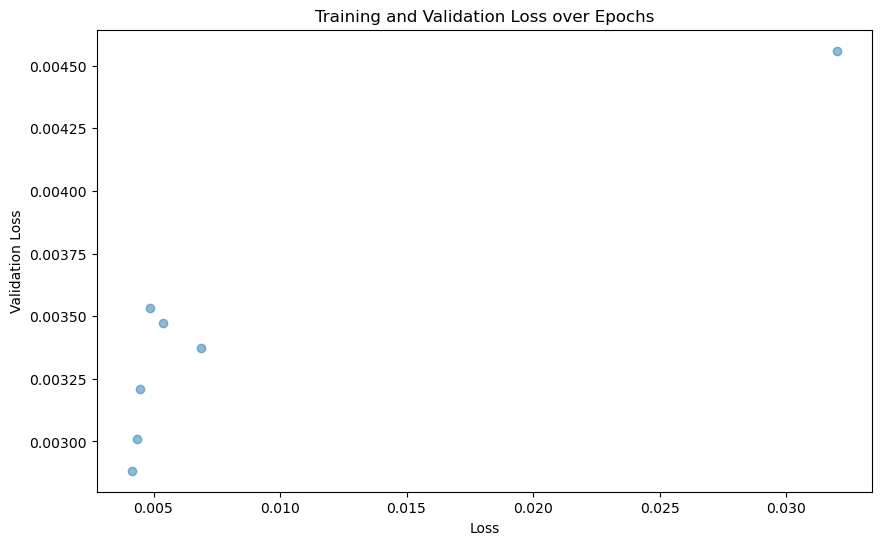

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(history.history['loss'], history.history['val_loss'], alpha=0.5)
plt.xlabel('Loss')
plt.ylabel('Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.show()

### Step 6: Evaluate on the test data and visualize the results

In [19]:
# Step 6: Evaluate and visualize
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

y_test_inv.shape, y_pred_inv.shape

316/316 [==============================] - 3s 7ms/step


((10099, 1), (10099, 1))

In [25]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-Squared: {r2:.4f}")

Mean Squared Error: 16985.7565
Root Mean Squared Error: 130.3294
R-Squared: 0.9707


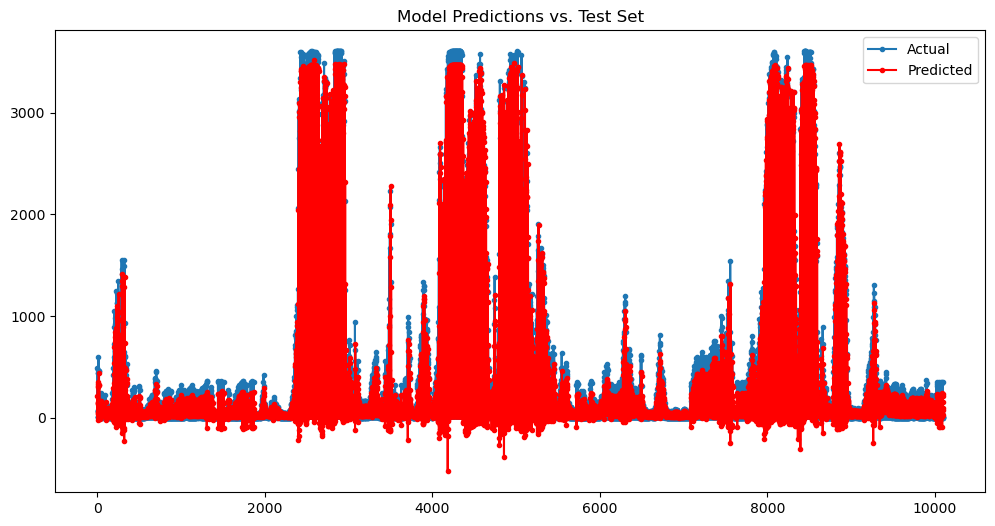

In [23]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv.flatten(), marker='.', label="Actual")
plt.plot(y_pred_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend()
plt.title('Model Predictions vs. Test Set')
plt.show()

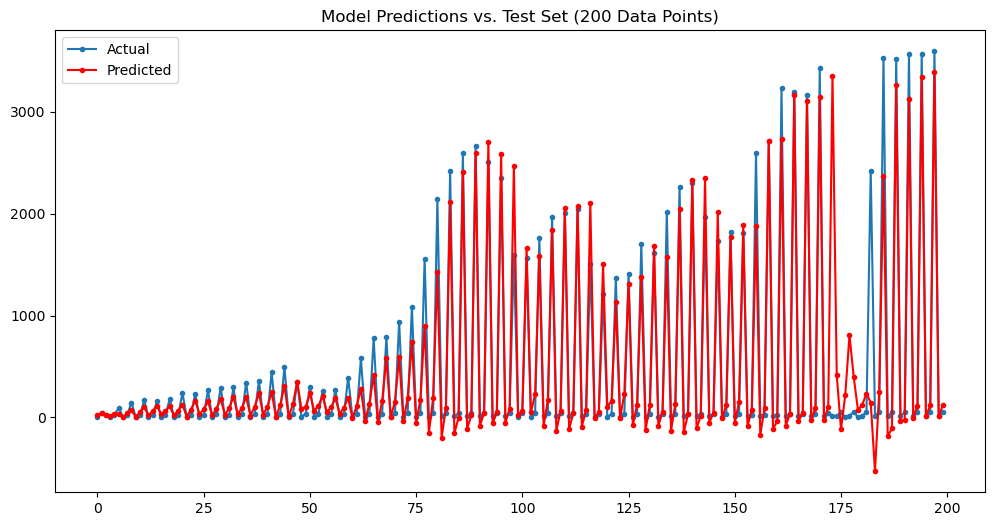

In [27]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv.flatten()[4000:4200], marker='.', label="Actual")
plt.plot(y_pred_inv.flatten()[4000:4200], 'r', marker='.', label="Predicted")
plt.legend()
plt.title('Model Predictions vs. Test Set (200 Data Points)')
plt.show()

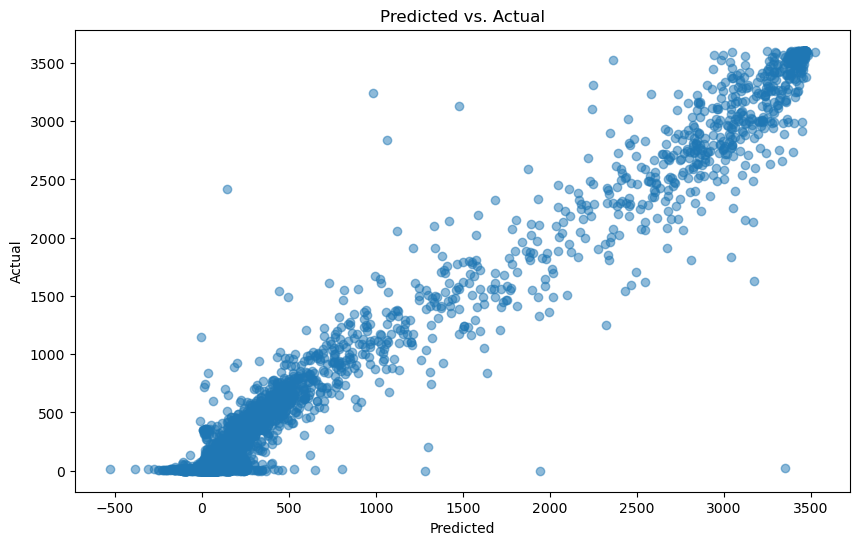

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_inv.flatten(), y_test_inv.flatten(), alpha=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual')
plt.show()